# Dados em painel (multi-series)

Em muitas aplicações, não temos acesso a uma única série temporal, mas sim a um conjunto de séries temporais relacionadas. Isso é comum em cenários como vendas de produtos em diferentes lojas, consumo de energia em diferentes regiões, etc. Esses dados são chamados de dados em painel.

Uma ideia poderosa é aproveitar a similaridade entre as séries para melhorar as previsões. Chamamos de **modelos globais** os modelos capazes de aprender padrões comuns entre as séries, ao contrário dos **modelos locais** que aprendem apenas com uma única série.

A maioria dos modelos clássicos de séries temporais são locais. Modelos globais são, em geral, baseados em modelos tabulares de ML ou deep learning. Segundo competições de séries temporais, como a M5, em forecasts de painel os modelos globais são os que apresentam melhor desempenho [@makridakis2022m5].


## Acessando os dados

Aqui, vamos usar o dataset sintético que vimos antes, mas agora teremos acesso às várias séries temporais que compõe o total.

Esse dataset é feito para simular um caso de varejo, onde temos vendas diárias de vários produtos:

In [1]:
# | echo: false
import warnings

warnings.filterwarnings("ignore")

In [2]:
# | code-fold: true
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series

In [3]:
from tsbook.datasets.retail import SyntheticRetail
dataset = SyntheticRetail("panel")
y_train, X_train, y_test, X_test = dataset.load(
    "y_train", "X_train", "y_test", "X_test"
)

Note que, para dados em painel, os dataframes possuem mais um nível de índice, que identifica a série temporal a que cada observação pertence:

In [4]:
display(X_train)

promo
sku_id date             
0      2020-01-01    0.0
       2020-01-02    0.0
       2020-01-03    0.0
       2020-01-04    0.0
       2020-01-05    0.0
...                  ...
24     2024-07-01    1.0
       2024-07-02    0.0
       2024-07-03    0.0
       2024-07-04    0.0
       2024-07-05    0.0

[41200 rows x 1 columns]

Podemos visualizar algumas séries. Vemos que há mais zeros nesse dataset, em comparação
ao que usamos antes.

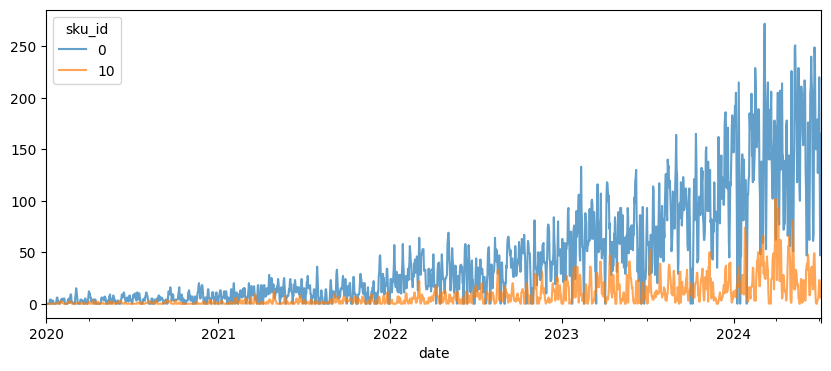

In [5]:
from sktime.utils.plotting import plot_series

fig, ax = plt.subplots(figsize=(10, 4))
y_train.unstack(level=0).droplevel(0, axis=1).iloc[:, [0,10]].plot(ax=ax, alpha=0.7)
plt.show()

### Pandas e multi-índices

Para trabalhar com essas estruturas de dados, é importante revisar algumas operações do pandas.

In [6]:
y_train.index.get_level_values(-1)

PeriodIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
             '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
             '2020-01-09', '2020-01-10',
             ...
             '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
             '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
             '2024-07-04', '2024-07-05'],
            dtype='period[D]', name='date', length=41200)

As seguintes operações são bem úteis para trabalhar com multi-índices:

In [7]:
y_train.index

MultiIndex([( 0, '2020-01-01'),
            ( 0, '2020-01-02'),
            ( 0, '2020-01-03'),
            ( 0, '2020-01-04'),
            ( 0, '2020-01-05'),
            ( 0, '2020-01-06'),
            ( 0, '2020-01-07'),
            ( 0, '2020-01-08'),
            ( 0, '2020-01-09'),
            ( 0, '2020-01-10'),
            ...
            (24, '2024-06-26'),
            (24, '2024-06-27'),
            (24, '2024-06-28'),
            (24, '2024-06-29'),
            (24, '2024-06-30'),
            (24, '2024-07-01'),
            (24, '2024-07-02'),
            (24, '2024-07-03'),
            (24, '2024-07-04'),
            (24, '2024-07-05')],
           names=['sku_id', 'date'], length=41200)

Acessar valores únicos no primeiro nivel (nível 0, mais à esquerda):

In [8]:
y_train.index.get_level_values(0).unique()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],
      dtype='int64', name='sku_id')

Selecionar uma série específica (nível 0 igual a 0):

In [9]:
y_train.loc[0]

,sales
date,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2024-07-01,220
2024-07-02,128
2024-07-03,47


Aqui, podemos usar `pd.IndexSlice` para selecionar várias séries ao mesmo tempo.
Note que pd.IndexSlice é passado diretamente para `.loc`:

In [10]:
y_train.loc[pd.IndexSlice[[0,2], :]]

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      0
       2020-01-03      0
       2020-01-04      0
       2020-01-05      0
...                  ...
2      2024-07-01    125
       2024-07-02    185
       2024-07-03    179
       2024-07-04    210
       2024-07-05    236

[3296 rows x 1 columns]

Agora, para selecionar o horizonte de forecasting, temos que chamar `unique`:

In [11]:
fh = y_test.index.get_level_values(1).unique()

fh

PeriodIndex(['2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09',
             '2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13',
             '2024-07-14', '2024-07-15',
             ...
             '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
             '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
             '2024-12-31', '2025-01-01'],
            dtype='period[D]', name='date', length=180)

## Upcasting automático

Nem todos modelos suportam nativamente dados em painel. Por exemplo, exponential smoothing.
Aqui, temos uma boa notícia: sem linhas extras necessárias. O sktime faz *upcasting* automático para dados em painel ao usar estimadores do `sktime`.

In [12]:
from sktime.forecasting.naive import NaiveForecaster


naive_forecaster = NaiveForecaster(strategy="last", window_length=1)
naive_forecaster.fit(y_train)
y_pred_naive = naive_forecaster.predict(fh=fh)

y_pred_naive

sales
sku_id date             
0      2024-07-06  165.0
       2024-07-07  165.0
       2024-07-08  165.0
       2024-07-09  165.0
       2024-07-10  165.0
...                  ...
24     2024-12-28  209.0
       2024-12-29  209.0
       2024-12-30  209.0
       2024-12-31  209.0
       2025-01-01  209.0

[4500 rows x 1 columns]

Internamente, o `sktime` cria um clone do estimador para cada série nos dados em painel.
Em seguida, cada clone é treinado com a série correspondente. Isso é feito de
forma transparente para usuário, mas sem exigir esforço.

O atributo `forecasters_` armazena um DataFrame com os estimatores de cada série.

In [13]:
naive_forecaster.forecasters_.head()

,forecasters
0,NaiveForecaster(window_length=1)
1,NaiveForecaster(window_length=1)
2,NaiveForecaster(window_length=1)
3,NaiveForecaster(window_length=1)
4,NaiveForecaster(window_length=1)


É dificil explicar o quanto isso é extremamente útil para código limpo e prototipagem rápida.
Foi um dos motivos que me levaram a usar o `sktime`.


## Métricas

Agora que temos várias séries, precisamos explicar como calcular métricas de avaliação.
O sktime oferece duas opções para isso, como argumentos na criação da métrica:

* `multilevel="uniform_average_time"` para calcular a média das séries temporais no painel.
* `multilevel="raw_values"` para obter o erro por série.


In [14]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

In [15]:
metric(y_true=y_test, y_pred=y_pred_naive, y_train=y_train)

np.float64(19.04893558607091)

Na prática, as métricas que a sua aplicação exige podem ser diferentes. Por exemplo,
as séries temporais podem ter diferentes importâncias, e você pode querer ponderar
as métricas de acordo. 

Para isso, é possível criar uma métrica customizada no sktime, mas não entraremos
nesse mérito aqui.

## Modelos globais de Machine Learning

Quando vimos como usar modelos de Machine Learning para forecasting, já mencionamos
como é necessário traduzir o problema de séries temporais para um problema de regressão tradicional.

No caso de dados em painel, também podemos usar essa abordagem, mas agora aproveitando
todas as séries temporais para treinar um único modelo global.
 
![](img/global_reduction.png)

Abaixo, vamos comparar um LightGBM global com um local. Veremos o seguinte: o modelo local é **melhor** que o modelo global, **se não processarmos os dados** corretamente para o modelo global aproveitar as **similaridades** entre as séries!

In [16]:
from tsbook.forecasting.reduction import ReductionForecaster
from lightgbm import LGBMRegressor

global_forecaster1 = ReductionForecaster(
    LGBMRegressor(n_estimators=100, verbose=-1, random_state=42),
    window_length=30,
)

global_forecaster1.fit(y_train, X_train)

ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                    window_length=30)

In [17]:
y_pred_global1 = global_forecaster1.predict(fh=fh, X=X_test)

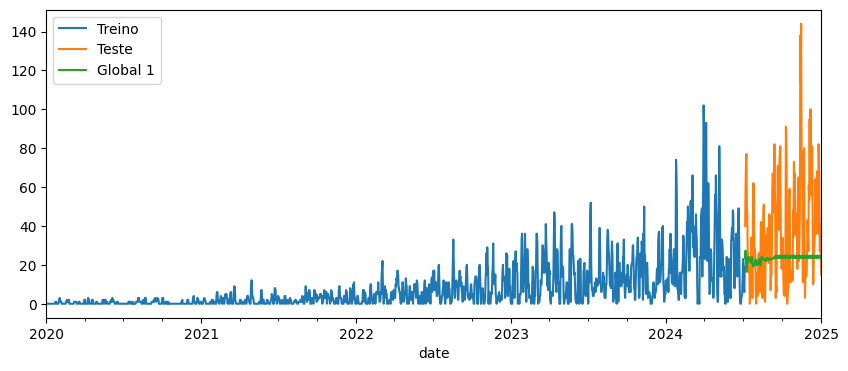

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[10, "sales"].plot(ax=ax, label="Treino")
y_test.loc[10, "sales"].plot(ax=ax, label="Teste")
y_pred_global1.loc[10, "sales"].plot(ax=ax, label="Global 1")
plt.legend()
plt.show()

Para forçar que um modelo global funcione como um modelo local, podemos usar `ForecastByLevel`, que cria um modelo separado para cada série temporal, mesmo quando o estimador suporta dados em painel.


In [19]:
from sktime.forecasting.compose import ForecastByLevel

local_forecaster1 = ForecastByLevel(global_forecaster1, groupby="local")

local_forecaster1.fit(y_train, X=X_train)

ForecastByLevel(forecaster=ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                               window_length=30))

In [20]:
y_pred_local1 = local_forecaster1.predict(fh=fh, X=X_test)

err_global1 = metric(y_true=y_test, y_pred=y_pred_global1, y_train=y_train)
err_local1 = metric(y_true=y_test, y_pred=y_pred_local1, y_train=y_train)

errors = pd.DataFrame(
    {
        "Global (1)": [err_global1],
        "Local (1)": [err_local1],
    },
    index=["MSE"],
)

## Preprocessamento e engenharia de features

Sabemos como preprocessar séries temporais univariadas para melhorar o desempenho dos modelos de ML. Aplicamos da mesma maneira que fizemos anteriormente o `Differencer`, com objetivo de remover tendências.

In [21]:
from sktime.transformations.series.difference import Differencer

global_forecaster2 = Differencer() * global_forecaster1
global_forecaster2.fit(y_train, X_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                                       window_length=30)])

In [22]:
y_pred_global2 = global_forecaster2.predict(fh=fh, X=X_test)
metric_global2 = metric(y_true=y_test, y_pred=y_pred_global2, y_train=y_train)

E agora sua versão local:

In [23]:
local_forecaster2 = ForecastByLevel(global_forecaster2, groupby="local")
local_forecaster2.fit(y_train, X=X_train)

y_pred_local2 = local_forecaster2.predict(fh=fh, X=X_test)
metric_local2 = metric(y_true=y_test, y_pred=y_pred_local2, y_train=y_train)

Agora, podemos comparar:

In [24]:
errors["Global (2)"] = metric_global2
errors["Local (2)"] = metric_local2

errors

,Global (1),Local (1),Global (2),Local (2)
MSE,41.057873,23.720592,22.238809,67.626298


Note como já superamos o modelo global incial. Isso é para
destacar que é **essencial** realizar um bom preprocessamento e engenharia de features para que modelos de Machine Learning tenham bom desempenho em dados em painel.

### Normalização por janela

Agora, vamos usar a normalização por janela, que é especialmente útil em dados em painel, onde as séries podem ter diferentes escalas.

In [25]:
global_forecaster3 = global_forecaster1.clone().set_params(
    normalization_strategy="divide_mean"
)

global_forecaster3.fit(y_train, X_train)

ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                    normalization_strategy='divide_mean', window_length=30)

In [26]:
# Predict
y_pred_global3 = global_forecaster3.predict(fh=fh, X=X_test)

# Métrica
metric_global3 = metric(y_true=y_test, y_pred=y_pred_global3, y_train=y_train)

errors["Global 3 (window norm)"] = metric_global3

display(errors)

,Global (1),Local (1),Global (2),Local (2),Global 3 (window norm)
MSE,41.057873,23.720592,22.238809,67.626298,15.317953


Vemos que resultados são ainda melhores!


### Pipelines de features exógenas

Podemos ajudar o modelo a capturar sazonalidades adicionando features de Fourier como features exógenas.

Usamos `**` para criar um pipeline aplicado sobre as features exógenas:

In [27]:
from sktime.transformations.series.fourier import FourierFeatures

fourier_features = FourierFeatures(
    sp_list=[365.25, 365.25 / 12], fourier_terms_list=[1, 1], freq="D"
)

global_forecaster4 = fourier_features**global_forecaster3
global_forecaster4.fit(y_train, X_train)

ForecastingPipeline(steps=[FourierFeatures(fourier_terms_list=[1, 1], freq='D',
                                           sp_list=[365.25, 30.4375]),
                           ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                               normalization_strategy='divide_mean',
                                               window_length=30)])

In [28]:
y_pred_global4 = global_forecaster4.predict(fh=fh, X=X_test)
metric_global4 = metric(y_true=y_test, y_pred=y_pred_global4, y_train=y_train)

errors["Global 4 (fourier)"] = metric_global4
errors

,Global (1),Local (1),Global (2),Local (2),Global 3 (window norm),Global 4 (fourier)
MSE,41.057873,23.720592,22.238809,67.626298,15.317953,15.143648


## Agrupamento + Modelos globais

Uma técnica muito adotada é fazer modelos globais por clusters de séries temporais similares. 

Uma maneira de categorizar é usando ADI (Average Demand Interval) e CV² (squared Coefficient of Variation). O componente ADI é calculado como o percentual de períodos com demanda (y>0), e $CV^2$ é o quadrado do coeficiente de variação das demandas positivas.

| **Categoria** | **ADI** | **CV²** | **Padrão típico** | **Exemplos** |
|:--------------|:--------|:--------|:------------------|:-------------|
| **Suave (Smooth)** | ≤ 1,32 | ≤ 0,49 | Demanda contínua e estável | Itens de consumo diário, alimentos |
| **Errática (Erratic)** | ≤ 1,32 | > 0,49 | Demanda contínua, porém muito variável | Moda, eletrônicos |
| **Intermitente (Intermittent)** | > 1,32 | ≤ 0,49 | Muitos períodos sem venda, mas valores estáveis quando ocorre | Peças de reposição, ferramentas |
| **Irregular (Lumpy)** | > 1,32 | > 0,49 | Muitos períodos com zero e valores muito variáveis quando há demanda | Equipamentos caros, sobressalentes grandes |


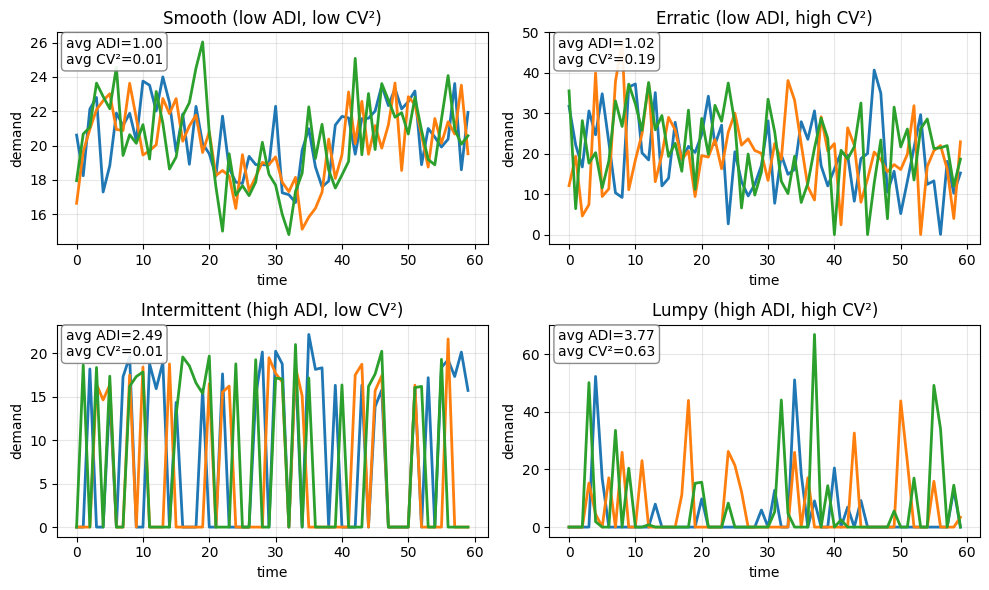

In [29]:
# | echo: false
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)


def compute_adi(y):
    nnz = np.count_nonzero(y > 0)
    return len(y) / nnz if nnz > 0 else np.inf


def compute_cv2(y):
    pos = y[y > 0]
    if len(pos) <= 1:
        return np.inf
    m = pos.mean()
    s = pos.std(ddof=1)
    return (s / m) ** 2 if m > 0 else np.inf


def plot_category(ax, series_list, title):
    x = np.arange(len(series_list[0]))
    for y in series_list:
        ax.plot(x, y, linewidth=2)
    adis = [compute_adi(y) for y in series_list]
    cv2s = [compute_cv2(y) for y in series_list]
    ax.text(
        0.02,
        0.98,
        f"avg ADI={np.mean(adis):.2f}\navg CV²={np.mean(cv2s):.2f}",
        transform=ax.transAxes,
        va="top",
        ha="left",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.5", alpha=0.9),
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("time")
    ax.set_ylabel("demand")
    ax.grid(True, alpha=0.3)


N = 60


def gen_smooth(n=3):
    out = []
    for _ in range(n):
        base = 20 + 2 * np.sin(np.linspace(0, 3 * np.pi, N))
        noise = rng.normal(0, 2, N)
        out.append(np.clip(base + noise, 0, None))
    return out


def gen_erratic(n=3):
    out = []
    for _ in range(n):
        base = 20 + 2 * np.sin(np.linspace(0, 2 * np.pi, N))
        noise = rng.normal(0, 9, N)
        out.append(np.clip(base + noise, 0, None))
    return out


def gen_intermittent(n=3):
    out = []
    for _ in range(n):
        mask = rng.binomial(1, 0.35, N)
        values = 18 + rng.normal(0, 2, N)
        out.append(np.clip(mask * values, 0, None))
    return out


def gen_lumpy(n=3):
    out = []
    for _ in range(n):
        mask = rng.binomial(1, 0.25, N)
        values = rng.gamma(shape=2.0, scale=10.0, size=N)
        out.append(np.clip(mask * values, 0, None))
    return out


cats = [
    ("Smooth (low ADI, low CV²)", gen_smooth()),
    ("Erratic (low ADI, high CV²)", gen_erratic()),
    ("Intermittent (high ADI, low CV²)", gen_intermittent()),
    ("Lumpy (high ADI, high CV²)", gen_lumpy()),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, (title, series) in zip(axes.ravel(), cats):
    plot_category(ax, series, title)

plt.tight_layout()
plt.show()

In [30]:
from sktime.forecasting.compose import GroupbyCategoryForecaster
from sktime.transformations.series.adi_cv import ADICVTransformer

# TODO: customize yours!
group_forecaster = GroupbyCategoryForecaster(
    forecasters =
        {"smooth": global_forecaster3.clone(),
        "erratic": global_forecaster3.clone(),
        "intermittent": global_forecaster3.clone(),
        "lumpy": global_forecaster3.clone(),
        },
    transformer=ADICVTransformer(features=["class"],))


group_forecaster.fit(y_train, X_train)

GroupbyCategoryForecaster(forecasters={'erratic': ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                                                      normalization_strategy='divide_mean',
                                                                      window_length=30),
                                       'intermittent': ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                                                           normalization_strategy='divide_mean',
                                                                           window_length=30),
                                       'lumpy': ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                                                    normalization_strategy='divide_mean',
                                                                    window_length=30),
                                       'smooth': ReductionForecaster(estimator=LGBMRegressor(random_state=42, verbose=-1),
                                                                     normalization_strategy='divide_mean',
                                                                     window_length=30)},
                          transformer=ADICVTransformer(features=['class']))

In [31]:
y_pred_group = group_forecaster.predict(fh=fh, X=X_test)
metric_group = metric(y_true=y_test, y_pred=y_pred_group, y_train=y_train)

metric_group

np.float64(53.56051503265084)

Although it did not perform better than the best global model in this synthetic example, in real-world scenarios this approach can be very effective, particularly when there are large samples for each category, allowing the model to learn specific patterns for each group of series.

In addition, this can be useful when there are computation constraints, as training multiple smaller models for each cluster can be more efficient than training a single large global model.


## Resumo

Aqui, vimos como trabalhar com dados em painel (multi-series) usando o sktime. Vimos, especialmente, como criar modelos globais de Machine Learning que aproveitam as similaridades entre as séries para melhorar o desempenho das previsões. Também destacamos a importância do preprocessamento e da engenharia de features para obter bons resultados com esses modelos.

Para uma análise mais aprofundada, recomendo o artigo de [@montero2021principles], que discute princípios para forecasting em dados em painel usando modelos globais de Machine Learning.
